In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

### Load the ground-truth and evaluate the methods

In [7]:
from intestine_info import load_processed_enterocyte_data, load_original_entero_zonation
from intestine_info import get_intestine_rna_lm_genes
from io_utils import load_all_pipeline_results, load_single_result
from io_utils import save_data_to_file
from plot_utils import plot_corr_mtx
from scrna_utils import get_gene_df
from general_utils import rank_and_bin

res_dir = "/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719"
zone_vals = load_original_entero_zonation(just_vals=True)
obs_df, var_df, mtx = load_processed_enterocyte_data(res_dir)
RDIR = os.path.join(res_dir, "entero_data", "results")
method = 'graph'
mtype = 'vanilla'
ddir = os.path.join(res_dir, 'entero_data', 'results', '{}_{}'.format(method, mtype))
os.makedirs(ddir, exist_ok=True)
fns = {
    'result': os.path.join(ddir, 'method_result.pkl'),
    'coeff_mtx': os.path.join(ddir, 'coeff_matrix.npy'),
    'embed_dict': os.path.join(ddir, 'embed_dict.pkl'),
}

[feat_viz INFO] {'Crypt': 0, 'V1': 1, 'V2': 2, 'V3': 3, 'V4': 4, 'V5': 5, 'V6': 6}


In [ ]:
# kmeans result 

In [18]:
ddir

'/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results/graph_vanilla'

In [8]:
result = load_single_result(RDIR, method, mtype)
save_data_to_file(result, fns['result'], 'pkl')

In [9]:
n_rej = len(result['rejections'])
n_genes = len(result['p_vals'])
print('Number of rejections: {} ({:.2f}%)'.format(n_rej, n_rej / n_genes * 100))

Number of rejections: 6892 (71.38%)


In [10]:
from spline_utils import setup_basis, spline_fit
from general_utils import rank_and_bin
# get the variable group ids
lam = result["lam_update"]
base_args = setup_basis(lam)
print(base_args)
p_fun, c_mtx = spline_fit(lam, mtx, base_args)
save_data_to_file(c_mtx, fns['coeff_mtx'], 'npy')

cr(x, knots=(0.0, 0.034))
Fitted 1000 parameters
Fitted 2000 parameters
Fitted 3000 parameters
Fitted 4000 parameters
Fitted 5000 parameters
Fitted 6000 parameters
Fitted 7000 parameters
Fitted 8000 parameters
Fitted 9000 parameters


In [11]:
from main_methods import compute_all_embeddings
embed_dict = compute_all_embeddings(result, c_mtx, mtx)
save_data_to_file(embed_dict, fns['embed_dict'], 'pkl')

Computing embedding for: all_coeffient
input dimension: (9656, 5)
Computing embedding for: all_expression
input dimension: (9656, 1383)
Computing embedding for: rejected_coeffient
input dimension: (6892, 5)
Computing embedding for: rejected_expression
input dimension: (6892, 1383)


In [62]:
# comparison with the kmeans clustering in the original paper
dat_dir = "/share/PI/sabatti/sc_data/intestine2k"
fn =  os.path.join(dat_dir, "extracted", "kmeans_meta.csv")
kdf = pd.read_csv(fn)
fn =  os.path.join(dat_dir, "extracted", "kmeans_data.csv")
kmtx = pd.read_csv(fn, header=None).values

In [63]:
kdf['curr_idx'] = kdf.index
kdf = kdf.set_index('gene_name')
gdf = var_df[['gene_ids']].copy()
gdf['orig_idx'] = gdf.index
gdf = gdf.set_index('gene_ids')
kdf['orig_idx'] = gdf.loc[kdf.index]['orig_idx']
kdf.head()

,indin,clust_idx,curr_idx,orig_idx
gene_name,,,,
Mrpl15,8,1,0,0
Lypla1,9,3,1,1
Arfgef1,40,3,2,14
Tram1,52,1,3,16
Rpl7,63,4,4,20


In [70]:
from main_methods import compute_embedding
moor = compute_embedding(kmtx)
ours = compute_embedding(c_mtx[kdf['orig_idx'], :])

input dimension: (2118, 7)
input dimension: (2118, 5)
input dimension: (2118, 1383)


In [95]:
from general_utils import norm_mtx
mm = norm_mtx(mtx[:, kdf['orig_idx']])
naive = compute_embedding(mm.T)
naive['umap 1'] = -naive['umap 1']

input dimension: (2118, 1383)


In [96]:
short_embed = {'moor': moor,  'naive': naive, 'ours': ours}

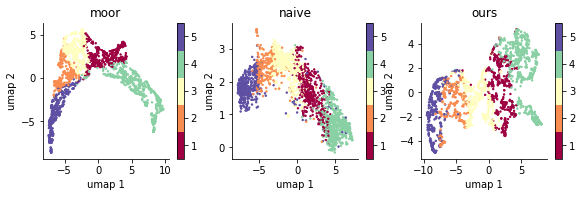

In [97]:
from plot_utils import plot_scatter_discrete
var_labs = kdf['clust_idx']
fig, axes = plt.subplots(1, len(short_embed), figsize=(3.2*len(short_embed),2.5))
for i, m in enumerate(short_embed.keys()):
    df = short_embed[m]
    ax = axes[i]
    plot_scatter_discrete(df[["umap 1", "umap 2"]].values, var_labs, ax=ax, ms=2)
    ax.set_title(m)
    ax.set_xlabel('umap 1')
    ax.set_ylabel('umap 2')
plt.show()

input dimension: (2118, 5)


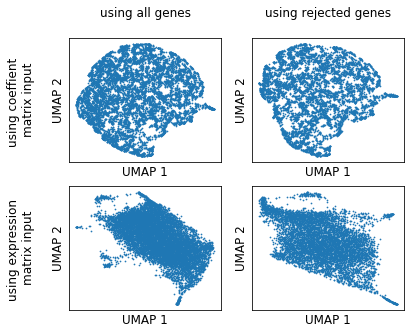

In [17]:
# plot the embeddings
fontsize = 12
sel_list = ["all", "rejected"]
mat_list = ["coeffient", "expression"]
fig, axes = plt.subplots(len(sel_list), len(mat_list), figsize=(3*len(mat_list), 2.5*len(sel_list)))
for i, sel in enumerate(sel_list):
    for j, mat in enumerate(mat_list):
        plt_df = embed_dict["{}_{}".format(sel, mat)]
        ax = axes[j, i]
        x = plt_df['umap 1']
        y = plt_df['umap 2']
        ax.scatter(x, y, s=0.5)
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_xlabel("UMAP 1", fontsize=fontsize)
        if j == 0:
            ax.set_title("using {} genes\n".format(sel), fontsize=fontsize)
        if i == 0:
            ax.set_ylabel("using {} \nmatrix input\n\nUMAP 2".format(mat), fontsize=fontsize)
        else:
            ax.set_ylabel("UMAP 2".format(mat), fontsize=fontsize)
plt.show()